# Implementation of a multi zone building thermal modelisation 

## DEFINITION DES CONSTANTES ET PARAMETRISATION

In [51]:
## PARAMETERS OF THE SIMULATION

# PIECE 
HAUTEUR_PIECE = 2.5
LARGEUR_PIECE = 5
LONGUEUR_PIECE = 10



#### VARIABLES UTILES AU CALCUL ####
# SURFACES
SURFACE_ROOF, SURFACE_FLOOR  = LARGEUR_PIECE * LONGUEUR_PIECE, LARGEUR_PIECE * LONGUEUR_PIECE
SURFACE_N , SURFACE_S = HAUTEUR_PIECE * LARGEUR_PIECE, HAUTEUR_PIECE * LARGEUR_PIECE
SURFACE_E , SURFACE_W = HAUTEUR_PIECE * LONGUEUR_PIECE, HAUTEUR_PIECE * LONGUEUR_PIECE
Surfaces = {"N": SURFACE_N, "S": SURFACE_S, "E": SURFACE_E, "W": SURFACE_W, "Roof": SURFACE_ROOF, "Floor": SURFACE_FLOOR}

# Mur intérieur : concrete on 0.1 m + LDR on 0.1 m + concrete on 0.1 m
# Mur extérieur : concrete on 0.2 m + LDR on 0.2 m + concrete on 0.1 m
# Floor and roof : concrete on 0.2 m

LAMBDA_BETON = 1.75
LAMBDA_LDR = 0.041

MUR_INTERIEUR_LAMBDA = [LAMBDA_BETON, LAMBDA_LDR, LAMBDA_BETON]
MUR_EXTERIEUR_LAMBDA = [LAMBDA_BETON, LAMBDA_LDR, LAMBDA_BETON]
PLANCHER_LAMBDA = [LAMBDA_BETON]
EPAISSEUR_MUR_INTERIEUR = [0.1, 0.1, 0.1]
EPAISSEUR_MUR_EXTERIEUR = [0.2, 0.2, 0.1]
EPAISSEUR_PLANCHER = [0.2]


# CALCUL DES RESISTANCES THERMIQUES
def resistance_thermique(epaisseur, lambda_):
    return epaisseur / lambda_

def calculer_resistance_thermique(epaisseurs, lambdas):
    return sum(e/l for e, l in zip(epaisseurs, lambdas))

H_MUR_INTERIEUR = calculer_resistance_thermique(EPAISSEUR_MUR_INTERIEUR, MUR_INTERIEUR_LAMBDA)
H_MUR_EXTERIEUR = calculer_resistance_thermique(EPAISSEUR_MUR_EXTERIEUR, MUR_EXTERIEUR_LAMBDA)
H_PLANCHER = calculer_resistance_thermique(EPAISSEUR_PLANCHER, PLANCHER_LAMBDA)

#### CALCUL DE RF ####
POURCENTAGE_COURVERTURE_FENETRE = 0.15

def calcul_RF(aire):
    R_INFILTRATION = 0.1 # K/W
    U_WINDOWS = 3.54 # W / K.m²
    R_WINDOWS = 1 / (U_WINDOWS * aire) # K/W
    RF = (R_INFILTRATION * R_WINDOWS) / (R_INFILTRATION + R_WINDOWS) # K/W
    return RF


#### CALCUL DE Ro ####
U_OFFICE = 2.5 # W / K.m²
SURFACE_MURALE = SURFACE_N + SURFACE_S + SURFACE_E + SURFACE_W + SURFACE_ROOF + SURFACE_FLOOR
RO = 1 / (U_OFFICE * SURFACE_MURALE) # K/W

#### CALCUL DE Cres ####
RO_AIR = 1.2 #kg/m³
C_AIR = 1000 # J/kg.K
VOLUME = LARGEUR_PIECE * LONGUEUR_PIECE * HAUTEUR_PIECE
CRES = RO_AIR * C_AIR * VOLUME # J/K

#### CALCUL DE CS ####
# Grosse approximation
EPAISSEUR_MATERIAU = 0.4 # m
VOLUME_MATERIAU = EPAISSEUR_MATERIAU * SURFACE_MURALE # m³
RO_MATERIAU = 2400 # kg/m³ (béton)
C_MATERIAU = 880 # J/kg.K (béton)
CS = RO_MATERIAU * C_MATERIAU * VOLUME_MATERIAU # J/K



## IMPORT

In [52]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## MODELE

In [53]:
class Zone: 
    def __init__(self, nom, initial_temp = 20):
        self.nom = nom
        self.liste_surface = {"N": "Ext", "S": "Ext", "E": "Ext", "W": "Ext", "Roof": "Ext", "Floor": "Ext"}
        self.Ri = None
        self.Rf = None
        self.Ro = RO
        self.Cs = CS
        self.Cres = CRES
        self.initial_temp = initial_temp
        self.neighbors = [] #list of tuple(zone, surface)
        self.neighbors_R = [] #list of tuple(zone, R_ij)

        # Time-varying parameters
        self.external_temp_series = None
        self.solar_gain_series = None
        self.internal_gain_series = None

    def get_lsit_surface(self):
        return self.liste_surface

    def set_time_series(self, time_points, external_temp, solar_gain, internal_gain):
        """
        Set time-dependent series for external temperature, solar gain, and internal gain.
        """
        self.external_temp_series = interp1d(time_points, external_temp, kind='linear', fill_value='extrapolate')
        self.solar_gain_series = interp1d(time_points, solar_gain, kind='linear', fill_value='extrapolate')
        self.internal_gain_series = interp1d(time_points, internal_gain, kind='linear', fill_value='extrapolate')

    def add_neighbor(self, zone, surface):
        self.neighbors.append((zone, surface))
        self.liste_surface[surface] = "Int"

        if surface == 'Floor' or surface == 'Roof':
            self.neighbors_R.append((zone, 1 / (Surfaces[surface] * H_PLANCHER)))
            #print(f"{zone}: Ajout d'une resistance de {surface}: {1 / (SURFACE_FLOOR * H_PLANCHER)}")
        else:   
            self.neighbors_R.append((zone, 1 / (Surfaces[surface] * H_MUR_INTERIEUR)))
            #print(f"{zone}: Ajout d'une resistance de mur {surface}: {1 / (Surfaces[surface] * H_MUR_INTERIEUR)}")

    def thermal_dynamics(self, t, y, all_zones_temp):
        """
        Defines differential equations with thermal exchange between zones.
        """
        Ts, Tint = y

        # Time-dependent values
        external_temp = self.external_temp_series(t)
        solar_gain = self.solar_gain_series(t)
        internal_gain = self.internal_gain_series(t)

        # Calculate the thermal exchange with neighboring zones
        neighbor_exchange = sum(
            (all_zones_temp[neighbor.nom] - Tint) / R_ij
            for neighbor, R_ij in self.neighbors_R
        )

        # Differential equations with thermal exchange
        dTs_dt = (1 / self.Cs) * ((Tint - Ts) / self.Ri - (Ts - external_temp) / self.Ro + solar_gain)
        dTint_dt = (1 / self.Cres) * ((Ts - Tint) / self.Ri + (external_temp - Tint) / self.Rf + internal_gain + neighbor_exchange)
        return [dTs_dt, dTint_dt]
    
    def update_values(self):
        """ 
        Update the values of the thermal resistance in the differential equations.
        """
        liste_mur_ext = []
        for surface, type_surface in self.liste_surface.items():
            if type_surface == "Ext":
                liste_mur_ext.append(surface)
        ### CALCUL DE RI ###
        self.Ri = 0
        for surface in liste_mur_ext:
            if surface in ['Floor', 'Roof']:
                self.Ri += 1 / (Surfaces[surface] * H_PLANCHER)
            else:
                self.Ri += 1 / (Surfaces[surface] * H_MUR_EXTERIEUR)

        ### CALCUL DE RF ###
        total_surface_ext = sum(Surfaces[surface] for surface in liste_mur_ext)
        
        surface_fenetre = POURCENTAGE_COURVERTURE_FENETRE * total_surface_ext
        self.Rf = calcul_RF(surface_fenetre)


    def get_all_infos(self):
        print(f"Nom de la zone : {self.nom}")
        print(f"Les paramètres de la zone sont :")
        print(f"Initial temperature : {self.initial_temp}")
        print(f"Ri : {self.Ri} K/W") 
        print(f"Rf : {self.Rf} K/W")
        print(f"Ro : {self.Ro} K/W")
        print(f"Cs : {self.Cs} J/K")
        print(f"Cres : {self.Cres} J/K")
        print(f"Les voisins de la zone sont :")
        for (neighbor, surface), (_, R_ij) in zip(self.neighbors, self.neighbors_R):
            print(f"Voisin : {neighbor.nom}, surface : {surface}, resistance : {R_ij:.4f} K/W")
            
def ajouter_au_dessus(zone1, zone2):
    zone1.add_neighbor(zone2, "Roof")
    zone2.add_neighbor(zone1, "Floor")

def ajouter_a_cote_NS(zone1, zone2):
    zone1.add_neighbor(zone2, "N")
    zone2.add_neighbor(zone1, "S")

def ajouter_a_cote_EW(zone1, zone2):
    zone1.add_neighbor(zone2, "E")
    zone2.add_neighbor(zone1, "W")




## DEFINITION TEMPERATURE EXTERIEURE
Initialisation des séries temporelles et définition de la température extérieure

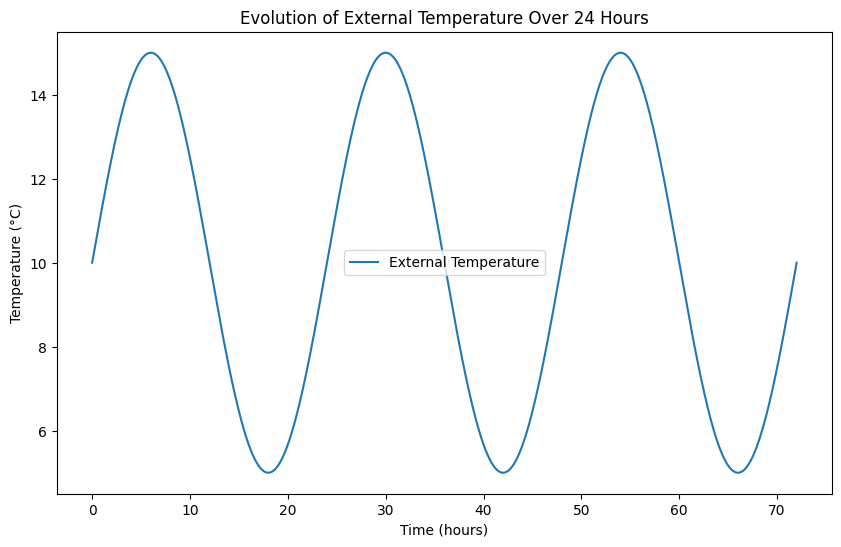

In [54]:
#### INITIALISATION DES SERIES TEMPORELLES ####
NB_JOURS = 3
time_points = np.linspace(0, NB_JOURS * 24 * 3600, NB_JOURS * 24 * 3600 + 1)
external_temp_values = 10 + 5 * np.sin(2 * np.pi * time_points / (24 * 3600))

# Profil d'évolution de la température externe
plt.figure(figsize=(10, 6))
plt.plot(time_points / 3600, external_temp_values, label="External Temperature")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Evolution of External Temperature Over 24 Hours")
plt.legend()
plt.show()

## DEFINITION SOLAR GAIN
On considère le gain solaire comme ceci : 
Irradiance en W/m2 * Surface vitrée en m2

Les surfaces vitrées représentent 15% des surfaces extérieures de la maison, toît compris.
Les profils d'irradiances sont différents selon chaque orientation (N, S, E, W, Roof) et on peut les visualiser ci-dessous

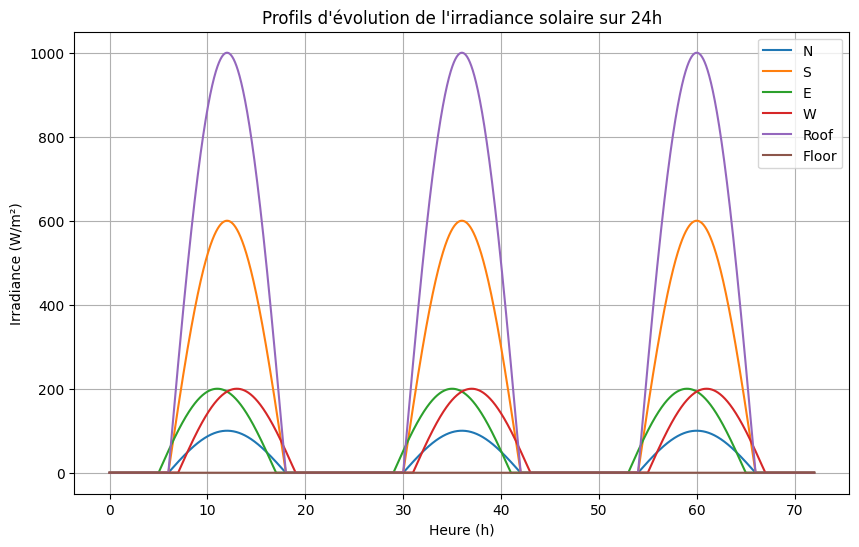

In [55]:
# Constantes
I_max = 1000  # Intensité maximale pour le toit (W/m²)
t_max = 12 * 3600  # Moment de l'intensité maximale (midi, en secondes)


# Profils d'évolution de l'irradiance solaire pour chaque surface
solar_profiles = {
    "N": np.clip(I_max * 0.1 * np.sin(2 * np.pi * (time_points - 6 * 3600) / (24 * 3600)), 0, None),
    "S": np.clip(I_max * 0.6 * np.cos(2 * np.pi * (time_points - 12 * 3600) / (24 * 3600)), 0, None),
    "E": np.clip(I_max * 0.2 * np.sin(2 * np.pi * (time_points - 5 * 3600) / (24 * 3600)), 0, None),
    "W": np.clip(I_max * 0.2 * np.sin(2 * np.pi * (time_points - 7* 3600) / (24 * 3600)), 0, None),
    "Roof": np.clip(I_max * np.cos(2 * np.pi * (time_points - 12* 3600) / (24 * 3600)), 0, None),
    "Floor": np.zeros_like(time_points),
}

# Affichage des profils
plt.figure(figsize=(10, 6))
for surface, profile in solar_profiles.items():
    plt.plot(time_points / 3600, profile, label=surface)  # Conversion du temps en heures

# Mise en forme du graphique
plt.title("Profils d'évolution de l'irradiance solaire sur 24h")
plt.xlabel("Heure (h)")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.show()


## CHOIX INTERNAL GAIN 

à définir en fonction du besoin, pour l'instant constant

In [56]:
liste_zone = ["Zone 01", "Zone 02", "Zone 11", "Zone 12", "Zone 21", "Zone 22"]

internal_gain_profiles = {
    zone : 200 + 100 * ((time_points % (24 * 3600)) > 8 * 3600) * ((time_points % (24 * 3600)) < 20 * 3600) for zone in liste_zone
}


In [57]:
internal_gain_profiles

{'Zone 01': array([200, 200, 200, ..., 200, 200, 200]),
 'Zone 02': array([200, 200, 200, ..., 200, 200, 200]),
 'Zone 11': array([200, 200, 200, ..., 200, 200, 200]),
 'Zone 12': array([200, 200, 200, ..., 200, 200, 200]),
 'Zone 21': array([200, 200, 200, ..., 200, 200, 200]),
 'Zone 22': array([200, 200, 200, ..., 200, 200, 200])}

## MODELISATION

On choisit le nombre de zones, leur agencement et on initialise leurs paramètres en fonction de ces choix

In [58]:
#### INITALISATION DES ZONES ####

zones = {nom: Zone(nom) for nom in liste_zone}

couple_haut_bas = [("Zone 01", "Zone 11"), ("Zone 02", "Zone 12"), ("Zone 11", "Zone 21"), ("Zone 12", "Zone 22")]
couple_cote = [("Zone 01", "Zone 02"), ("Zone 11", "Zone 12"), ("Zone 21", "Zone 22")]

for zone1, zone2 in couple_haut_bas:
    ajouter_au_dessus(zones[zone1], zones[zone2])
for zone1, zone2 in couple_cote:
    ajouter_a_cote_NS(zones[zone1], zones[zone2])



def get_solar_gain(profiles, time_points, zone):
    I_max = 1300 # W/m²
    t_max = 13 * 3600 # 13h

    list_surfaces = zone.liste_surface
    solar_gain = np.zeros_like(time_points, dtype=float)
    for surface in list_surfaces:
        if list_surfaces[surface] == "Ext":
            solar_gain += profiles[surface] * Surfaces[surface] * POURCENTAGE_COURVERTURE_FENETRE
    
    return solar_gain

def get_internal_gain(profiles, zone):
    return profiles[zone.nom]

for zone in zones.values():
    zone.update_values()

    solar_gain_values = get_solar_gain(solar_profiles, time_points, zone)
    internal_gain_values = 3 * get_internal_gain(internal_gain_profiles, zone)
                           
    zone.set_time_series(time_points, external_temp_values, solar_gain_values, internal_gain_values)
    


In [59]:
zones["Zone 01"].get_all_infos()

Nom de la zone : Zone 01
Les paramètres de la zone sont :
Initial temperature : 20
Ri : 0.20668644769528016 K/W
Rf : 0.01433948736332676 K/W
Ro : 0.002285714285714286 K/W
Cs : 147840000.0 J/K
Cres : 150000.0 J/K
Les voisins de la zone sont :
Voisin : Zone 11, surface : Roof, resistance : 0.1750 K/W
Voisin : Zone 02, surface : N, resistance : 0.0313 K/W


## CALCUL

In [62]:
# Combined dynamics function
def combined_dynamics(t, y):
    all_zones_temp = {}
    index = 0
    for nom, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        all_zones_temp[nom] = Tint
        index += 2
    
    dydt = []
    index = 0
    for nom, zone in zones.items():
        Ts, Tint = y[index], y[index + 1]
        dTs_dt, dTint_dt = zone.thermal_dynamics(t, [Ts, Tint], all_zones_temp)
        dydt.extend([dTs_dt, dTint_dt])
        index += 2
    return dydt

# Initial conditions for each zone's Ts and Tint
initial_conditions = []
for zone in zones.values():
    initial_conditions.extend([zone.initial_temp, zone.initial_temp])

# Simulate over 24 hours
time_span = (0, NB_JOURS * 24 * 3600)
time_eval = np.linspace(time_span[0], time_span[1], NB_JOURS * 24 * 3600 + 1)

print("Début du calcul")
solution = solve_ivp(combined_dynamics, time_span, initial_conditions, t_eval=time_eval)
print("Pas de soucis avec le calcul")

Début du calcul
Pas de soucis avec le calcul


## RESULTATS

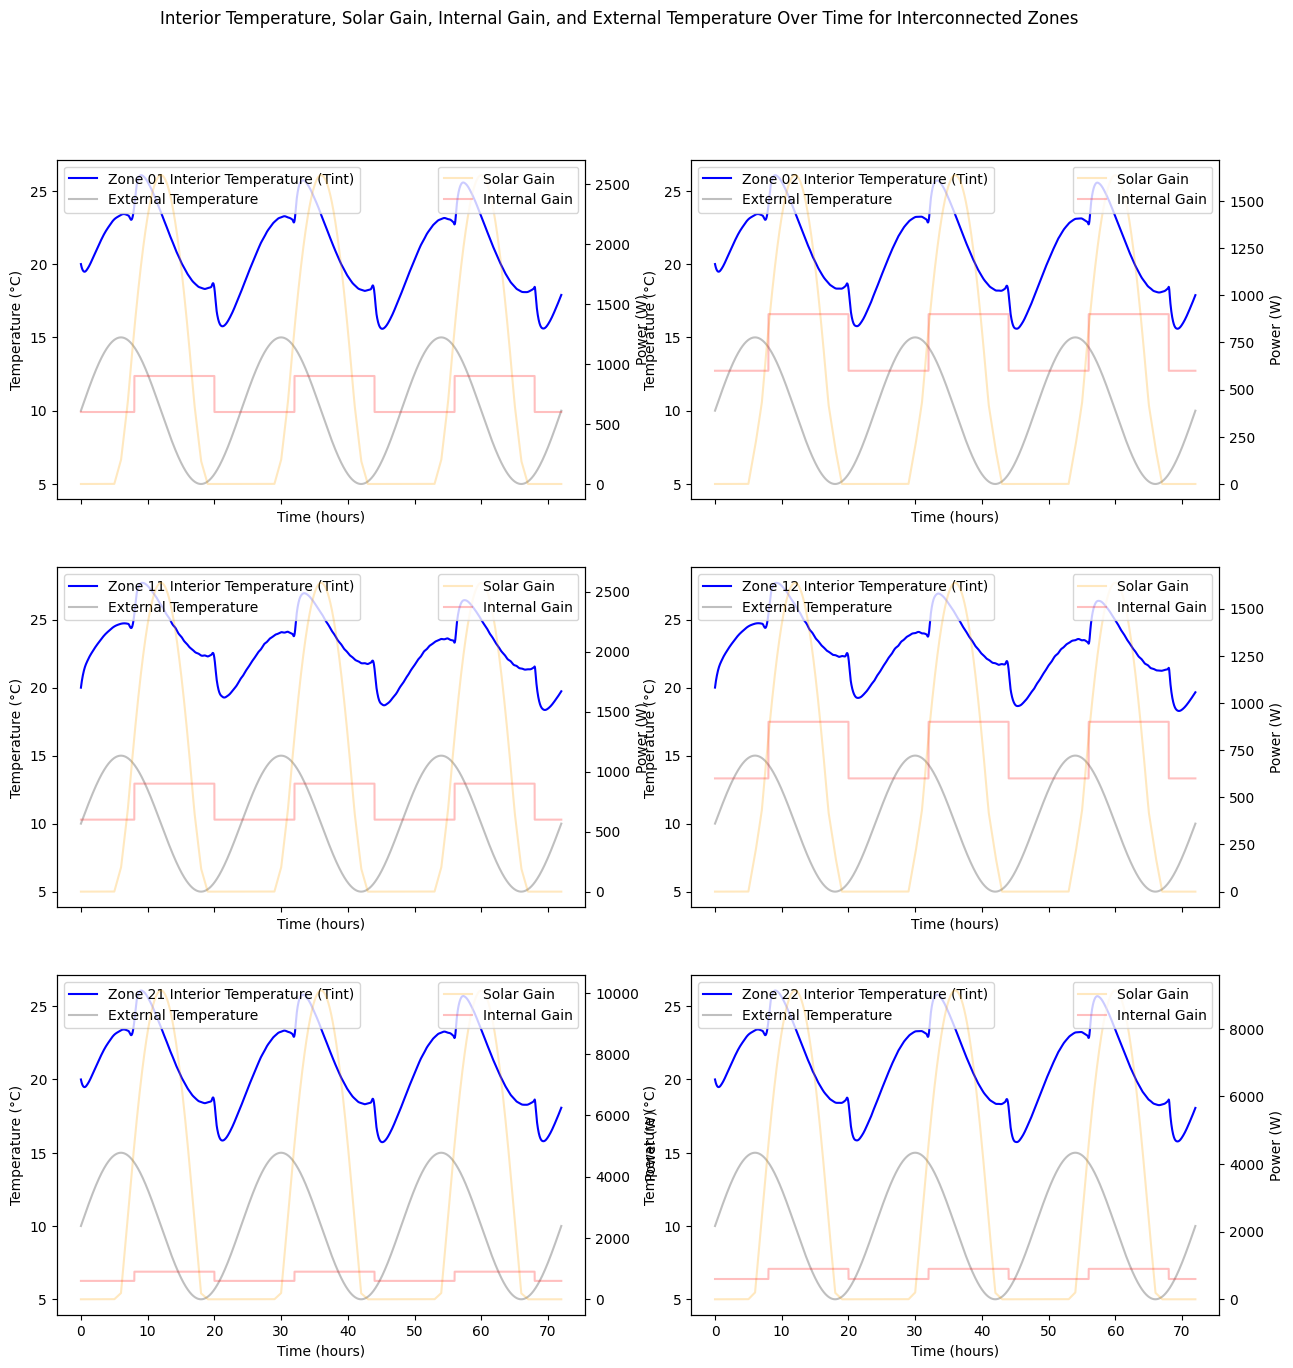

In [63]:
# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot interior temperature for each zone
for i, (nom, zone) in enumerate(zones.items()):
    Tint = solution.y[i * 2 + 1]  # Extract Tint for each zone
    solar_gain = zone.solar_gain_series(time_eval)
    internal_gain = zone.internal_gain_series(time_eval)
    
    ax1 = axes[i]
    ax1.plot(solution.t / 3600, Tint, label=f"{nom} Interior Temperature (Tint)", color='blue')
    ax1.plot(solution.t / 3600, external_temp_values, label="External Temperature", color='black', alpha=0.25)
    ax1.set_ylabel("Temperature (°C)")
    ax1.legend(loc="upper left")
    
    ax2 = ax1.twinx()
    ax2.plot(solution.t / 3600, solar_gain, label="Solar Gain", color='orange', alpha=0.25)
    ax2.plot(solution.t / 3600, internal_gain, label="Internal Gain", color='red', alpha=0.25)
    ax2.set_ylabel("Power (W)")
    ax2.legend(loc="upper right")

# Set common labels
for ax in axes:
    ax.set_xlabel("Time (hours)")

fig.suptitle("Interior Temperature, Solar Gain, Internal Gain, and External Temperature Over Time for Interconnected Zones")

plt.show()